<a href="https://colab.research.google.com/github/MustofAhmed41/3D-Jeep-Car/blob/main/Pretrained%20FedAvg%20Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import os
import json
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

In [16]:
tf.random.set_seed(42)
np.random.seed(42)

layers_shape = []
global_loss = []
global_accuracy = []

comm_rounds = 3
local_epoch = 1
local_batch_size = 32
clients_size = 2
num_of_classes = 10
pre_train_epoch = 1

In [17]:
from tensorflow.keras.datasets import mnist

import numpy as np

# Load the MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 784)).astype('float64') / 255
test_images = test_images.reshape((10000, 784)).astype('float64') / 255
# Create a list to hold the data for each client
clients_data = [[] for _ in range(clients_size)]

# Shuffle the dataset
indices = np.random.permutation(len(train_images))
shuffled_images = train_images[indices]
shuffled_labels = train_labels[indices]

# Partition the data equally among n clients
for i in range(len(shuffled_images)):
    label = shuffled_labels[i]
    client_idx = i % clients_size  # Distribute evenly among n clients
    clients_data[client_idx].append((shuffled_images[i], label))

# Convert the list of lists to numpy arrays
clients_data = [np.array(client_data) for client_data in clients_data]

# Verify that all clients have an equal number of labels for all 10 digits
for i, client_data in enumerate(clients_data):
    labels, counts = np.unique(client_data[:, 1], return_counts=True)
    print(f"Client {i} label distribution: {dict(zip(labels, counts))}")


Client 0 label distribution: {0: 2984, 1: 3367, 2: 2929, 3: 3069, 4: 2858, 5: 2727, 6: 2989, 7: 3119, 8: 2984, 9: 2974}
Client 1 label distribution: {0: 2939, 1: 3375, 2: 3029, 3: 3062, 4: 2984, 5: 2694, 6: 2929, 7: 3146, 8: 2867, 9: 2975}


<ipython-input-17-6f7b482f897c>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clients_data = [np.array(client_data) for client_data in clients_data]


In [18]:
layer_names_lst = ["layer_1_", "layer_2_", "layer_3_"]
model_names_lst = []
weights_biases = ["weights.csv", "biases.csv"]

for i in range(1, len(clients_data)+1):
  model = "model_" + str(i) + "_"
  model_names_lst.append(model)

print(layer_names_lst)
print(model_names_lst)

['layer_1_', 'layer_2_', 'layer_3_']
['model_1_', 'model_2_']


In [19]:
def get_model_weights(layer_name):
  weight_file_name = layer_name + "_weights.csv"
  bias_file_name = layer_name + "_biases.csv"
  weight = my_array = np.loadtxt(weight_file_name, delimiter=',')
  biases = my_array = np.loadtxt(bias_file_name, delimiter=',')
  return [weight, biases]

In [20]:
def fed_avg():
  for i,layer_name in enumerate(layer_names_lst):
    temp = np.zeros((layers_shape[i][0][0], layers_shape[i][0][1]))
    for j, model_name in enumerate(model_names_lst):
      file_name  = model_name + layer_name + weights_biases[0]
      temp = temp + np.loadtxt(file_name, dtype=np.float64, delimiter=",")
    temp = temp / clients_size
    save_file_name = 'aggregated_' + layer_name + weights_biases[0]
    np.savetxt(save_file_name, temp, delimiter=',')

  for i,layer_name in enumerate(layer_names_lst):
    temp = np.zeros((layers_shape[i][1][0]))
    for j, model_name in enumerate(model_names_lst):
      file_name  = model_name + layer_name + weights_biases[1]
      temp = temp + np.loadtxt(file_name, dtype=np.float64, delimiter=",")
    temp = temp / clients_size
    save_file_name = 'aggregated_' + layer_name + weights_biases[1]
    np.savetxt(save_file_name, temp, delimiter=',')

In [21]:
def evaluate_global_model():
  latest_model = keras.models.Sequential()
  latest_model.add(keras.layers.Dense(256, weights=get_model_weights("aggregated_layer_1"),  activation='relu',  input_shape=(784,), name="layer_1"))
  latest_model.add(keras.layers.Dense(512, weights=get_model_weights("aggregated_layer_2"),  activation='relu',  name="layer_2"))
  latest_model.add(keras.layers.Dense(num_of_classes, weights=get_model_weights("aggregated_layer_3"), activation='softmax',  name="layer_3"))

  latest_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  loss, accuracy = latest_model.evaluate(test_images,  test_labels, verbose=2)
  global_loss.append(loss)
  global_accuracy.append(accuracy)

In [22]:
global_model = models.Sequential()

global_model.add(layers.Dense(256, input_shape=(784,),  activation='relu', name="layer_1"))
global_model.add(layers.Dense(512, activation='relu', name="layer_2"))
global_model.add(layers.Dense(num_of_classes, activation='softmax', name="layer_3"))

global_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
dataset = tf.data.Dataset.from_tensor_slices((train_images[:5000], tf.keras.utils.to_categorical(train_labels[:5000], num_of_classes))).shuffle(len(train_images)).batch(local_batch_size)

global_model.fit(dataset, epochs=pre_train_epoch)
loss, accuracy  = global_model.evaluate(test_images,  tf.keras.utils.to_categorical(test_labels, num_of_classes), verbose=2)
print(accuracy)

157/157 [==============================] - 2s 6ms/step - loss: 0.5400 - accuracy: 0.8404
313/313 - 1s - loss: 0.2855 - accuracy: 0.9151 - 791ms/epoch - 3ms/step
0.9150999784469604


In [23]:
for layer in global_model.layers:
  if hasattr(layer, 'weights'):
    weights = layer.get_weights()
    for i, weight in enumerate(weights):
      file_name = "global_model_" + str(layer.name)
      if i == 0:
        file_name = file_name + "_weights.csv"
        # print(file_name)
        np.savetxt(file_name, weight, delimiter=',')
      else:
        file_name = file_name + "_biases.csv"
        # print(file_name)
        np.savetxt(file_name, weight, delimiter=',')

In [24]:
for k in range(comm_rounds):
  print("Communication Round " + str(k))
  for j,client_data in enumerate(clients_data):
    # Split the data into features (images) and labels
    client_images, client_labels = list(client_data[:, 0]), list(client_data[:, 1])

    # Convert the labels to one-hot encoding
    client_labels = tf.keras.utils.to_categorical(client_labels, num_of_classes)

    # Create a TensorFlow Dataset from the NumPy arrays
    dataset = tf.data.Dataset.from_tensor_slices((client_images, client_labels)).shuffle(len(client_images)).batch(local_batch_size)

    # Define the model architecture
    model = models.Sequential()
    if k==0:
      model.add(layers.Dense(256, weights=get_model_weights("global_model_layer_1"), input_shape=(784,),  activation='relu', name="layer_1"))
      model.add(layers.Dense(512, weights=get_model_weights("global_model_layer_2"), activation='relu', name="layer_2"))
      model.add(layers.Dense(num_of_classes, weights=get_model_weights("global_model_layer_3"),  activation='softmax', name="layer_3"))
    else:
      model.add(keras.layers.Dense(256, weights=get_model_weights("aggregated_layer_1"),  activation='relu',  input_shape=(784,), name="layer_1"))
      model.add(keras.layers.Dense(512, weights=get_model_weights("aggregated_layer_2"),  activation='relu',  name="layer_2"))
      model.add(keras.layers.Dense(num_of_classes, weights=get_model_weights("aggregated_layer_3"), activation='softmax',  name="layer_3"))


    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model using the TensorFlow Dataset
    print("Training Client " + str(j) + " in round " +  str(k))
    model.fit(dataset, epochs=local_epoch)

    for layer in model.layers:
      if hasattr(layer, 'weights'):
        weights = layer.get_weights()
        for i, weight in enumerate(weights):
          file_name = "model_" + str(j+1) + "_" + str(layer.name)
          if i == 0:
            file_name = file_name + "_weights.csv"
            # print(file_name)
            np.savetxt(file_name, weight, delimiter=',')
          else:
            file_name = file_name + "_biases.csv"
            # print(file_name)
            np.savetxt(file_name, weight, delimiter=',')

    if k == 0 and j==0:
      for layer in model.layers:
        if hasattr(layer, 'weights'):
          weights = layer.get_weights()
          temp = []
          for i, weight in enumerate(weights):
            temp.append(weight.shape)

          layers_shape.append(temp)

  fed_avg()
  evaluate_global_model()


Communication Round 0
Training Client 0 in round 0
938/938 [==============================] - 7s 7ms/step - loss: 0.1878 - accuracy: 0.9428
Training Client 1 in round 0
938/938 [==============================] - 6s 6ms/step - loss: 0.1936 - accuracy: 0.9399
313/313 - 1s - loss: 0.1058 - accuracy: 0.9664 - 836ms/epoch - 3ms/step
Communication Round 1
Training Client 0 in round 1
938/938 [==============================] - 7s 7ms/step - loss: 0.1137 - accuracy: 0.9655
Training Client 1 in round 1
938/938 [==============================] - 7s 7ms/step - loss: 0.1164 - accuracy: 0.9636
313/313 - 1s - loss: 0.0799 - accuracy: 0.9746 - 859ms/epoch - 3ms/step
Communication Round 2
Training Client 0 in round 2
938/938 [==============================] - 7s 7ms/step - loss: 0.0821 - accuracy: 0.9738
Training Client 1 in round 2
938/938 [==============================] - 7s 7ms/step - loss: 0.0838 - accuracy: 0.9740
313/313 - 1s - loss: 0.0694 - accuracy: 0.9774 - 869ms/epoch - 3ms/step


In [25]:
global_loss = np.array(global_loss)
global_accuracy = np.array(global_accuracy)
print(global_loss)
print(global_accuracy)
print(len(global_loss))

[0.10581233 0.07986742 0.06937088]
[0.96640003 0.97460002 0.9774    ]
3


In [26]:
# global_loss = global_loss.tolist()
# global_accuracy = global_accuracy.tolist()

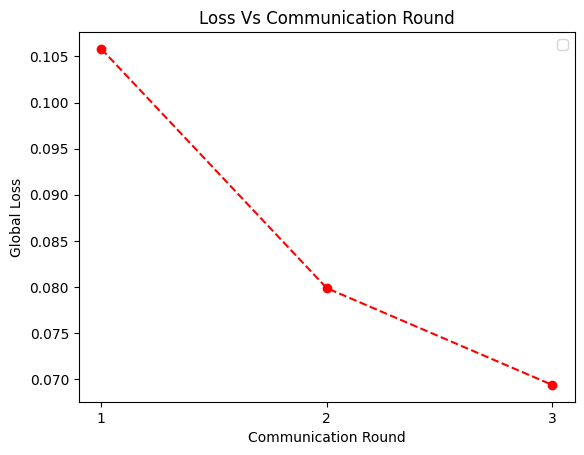

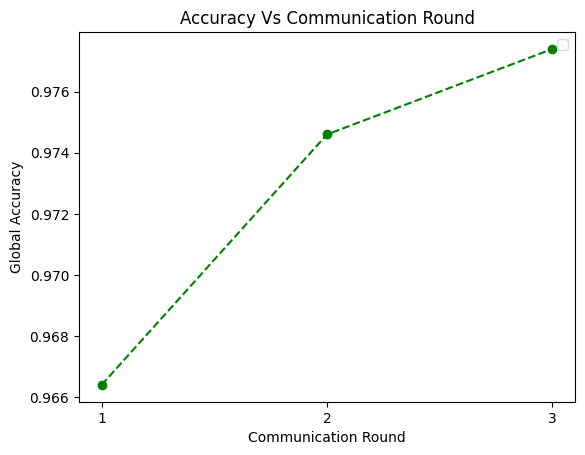

In [27]:

x_values = np.arange(1, len(global_loss) + 1)
# Plotting the graph
plt.plot(x_values, global_loss, marker='o', linestyle='--', color='r')
plt.title('Loss Vs Communication Round')
plt.xlabel('Communication Round')
plt.ylabel('Global Loss')
plt.xticks(x_values)
plt.legend()
plt.show()

# Plot the accuracy values

x_values = np.arange(1, len(global_accuracy) + 1)
# Plotting the graph
plt.plot(x_values, global_accuracy, marker='o', linestyle='--', color='g')
plt.title('Accuracy Vs Communication Round')
plt.xlabel('Communication Round')
plt.ylabel('Global Accuracy')
plt.xticks(x_values)
plt.legend()
plt.show()